In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve


In [3]:
df = pd.read_csv("german_credit_data.csv")
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (1000, 11)


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
if "Unnamed: 0" in df.columns:
    df = df.drop("Unnamed: 0", axis=1)


cat_cols = df.select_dtypes(include=["object"]).columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


X = df.drop("Risk", axis=1)
y = LabelEncoder().fit_transform(df["Risk"])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


scaler_path = "scaler.pkl"
if os.path.exists(scaler_path):
    scaler = joblib.load(scaler_path)
    print("✅ Loaded saved scaler")
else:
    scaler = StandardScaler()
    scaler.fit(X_train)
    joblib.dump(scaler, scaler_path)
    print("📌 Trained and saved new scaler")

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


✅ Loaded saved scaler


In [5]:
print(df.columns)


Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    filename = f"{name.replace(' ', '_')}.pkl"
    if os.path.exists(filename):
        models[name] = joblib.load(filename)
        print(f"✅ Loaded saved {name}")
    else:
        model.fit(X_train, y_train)
        joblib.dump(model, filename)
        print(f"📌 Trained and saved {name}")


✅ Loaded saved Logistic Regression
✅ Loaded saved Decision Tree
✅ Loaded saved Random Forest


In [7]:
from sklearn.metrics import classification_report, roc_auc_score

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n🔹 {name} Results:")
    print(classification_report(y_test, y_pred))

    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print(f"AUC: {auc:.4f}")



🔹 Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.62      0.38      0.47        60
           1       0.77      0.90      0.83       140

    accuracy                           0.74       200
   macro avg       0.70      0.64      0.65       200
weighted avg       0.73      0.74      0.72       200

AUC: 0.7636

🔹 Decision Tree Results:
              precision    recall  f1-score   support

           0       0.45      0.40      0.42        60
           1       0.76      0.79      0.77       140

    accuracy                           0.68       200
   macro avg       0.60      0.60      0.60       200
weighted avg       0.66      0.68      0.67       200

AUC: 0.5964

🔹 Random Forest Results:
              precision    recall  f1-score   support

           0       0.60      0.47      0.52        60
           1       0.79      0.86      0.83       140

    accuracy                           0.74       200
   macro avg       0

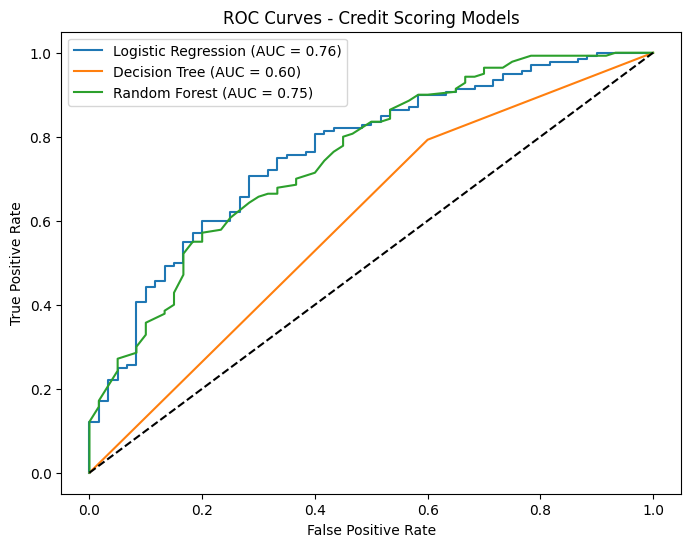

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(8,6))
for name, model in models.items():
    y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Credit Scoring Models")
plt.legend()
plt.show()


In [9]:
def predict_new_applicant(applicant_data, model_name="Random Forest"):
    if model_name not in models:
        raise ValueError(f"Model '{model_name}' not found. Choose from {list(models.keys())}")

    input_df = pd.DataFrame([applicant_data])
    input_scaled = scaler.transform(input_df)

    model = models[model_name]
    pred = model.predict(input_scaled)[0]
    prob = model.predict_proba(input_scaled)[0][1]

    result = "Good Credit" if pred == 1 else "Bad Credit"
    print(f"✅ Final Prediction: {result} with {prob*100:.2f}% probability")


In [10]:
new_applicant = {
    "Age":35,
    "Sex":1,
    "Job":2,
    "Housing":1,
    "Saving accounts":2,
    "Checking account":1,
    "Credit amount":2000,
    "Duration":24,
    "Purpose":3
}

predict_new_applicant(new_applicant,model_name="Random Forest")

✅ Final Prediction: Good Credit with 69.00% probability
